<a href="https://colab.research.google.com/github/andersthequeen/cis545/blob/master/538_Presidential_Election_Confidence_Interval_Review.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#538 Presidential Election Confidence Interval Review

The purpose of this short piece of code is to scrape from NYT's election data, discern the voting percentages of the incumbent (Trump) and challenger (Biden), and evaluate how 538's projected confidence intervals lined up with the true results of the 2020 Presidential Election.


##Scraping from New York Times
https://www.nytimes.com/interactive/2020/11/03/us/elections/results-virginia.html?action=click&module=ELEX_results&pgtype=Interactive&region=FooterNavigation
https://www.nytimes.com/interactive/2020/11/03/us/elections/results-california-president.html


In [26]:
%%capture
!pip3 install requests_html

import re
import urllib
import requests
import pandas as pd
from lxml import html
from lxml import etree
from io import StringIO, BytesIO
from requests_html import HTML, HTMLSession
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup

In [180]:
session = HTMLSession()
election_urls = []
scrape_df = pd.DataFrame(columns = ['state', 'd_real', 'r_real'])
url = "https://www.nytimes.com/interactive/2020/11/03/us/elections/results-president.html?action=click&pgtype=Article&state=default&module=styln-elections-2020&region=TOP_BANNER&context=election_recirc"
r = session.get(url)
soup = BeautifulSoup(r.text, 'html.parser')

for a in soup.find_all('a', {'class': 'e-text-color e-democrat'}):
  election_urls.append(a['href'])
for b in soup.find_all('a', {'class': 'e-text-color e-republican'}):
  election_urls.append(b['href'])
election_urls = list(dict.fromkeys(election_urls))

for url in election_urls:
  r = session.get(url)
  soup = BeautifulSoup(r.text, 'html.parser')
  party = soup.findAll("span", attrs = {"class": "e-party-display"})
  percent = soup.findAll("span", attrs = {"class": "e-percent-val"})

  if(str(party[0].contents[0]) == "Democrat"):
    d_real = float(percent[0].contents[0])
    r_real = float(percent[1].contents[0])
  else:
    d_real = float(percent[1].contents[0])
    r_real = float(percent[0].contents[0])
  
  state = str(url).split('results-')[1].split('-president')[0]

  scrape_df = scrape_df.append({'state' : state, 'd_real' : d_real, 'r_real' : r_real}, ignore_index = True)

## Using open-source data from 538

In [150]:
from google.colab import files
uploaded = files.upload()

Saving presidential_state_toplines_2020.csv to presidential_state_toplines_2020.csv


In [181]:
import io
df_538 = pd.read_csv(io.BytesIO(uploaded['presidential_state_toplines_2020.csv']))
df_538 = df_538[df_538['modeldate'].str.contains('11/3/20')]
df_538 = df_538[['state','voteshare_inc_hi', 'voteshare_chal_hi', 'voteshare_inc_lo', 'voteshare_chal_lo']]
df_538['state'] = df_538['state'].apply(lambda x: x.replace(' ', '-').lower())
df_538.head(5)

,state,voteshare_inc_hi,voteshare_chal_hi,voteshare_inc_lo,voteshare_chal_lo
0,wyoming,70.99022,36.18585,60.52768,25.93248
1,wisconsin,48.68993,56.99251,42.07389,50.39740
2,west-virginia,70.77528,40.13931,58.12693,27.47620
3,washington,42.22951,65.99652,31.79709,55.51974
4,virginia,46.40628,58.82807,40.23785,52.66484


In [209]:
master_df = df_538.merge(scrape_df, how = 'inner', on = 'state')
master_df.head(5)

,state,voteshare_inc_hi,voteshare_chal_hi,voteshare_inc_lo,voteshare_chal_lo,d_real,r_real
0,wyoming,70.99022,36.18585,60.52768,25.93248,26.60,70.00
1,wisconsin,48.68993,56.99251,42.07389,50.39740,49.45,48.83
2,west-virginia,70.77528,40.13931,58.12693,27.47620,29.60,68.60
3,washington,42.22951,65.99652,31.79709,55.51974,58.80,38.70
4,virginia,46.40628,58.82807,40.23785,52.66484,54.10,44.30


In [ ]:
"import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Setup a plot such that only the bottom spine is shown
def setup(ax):
    ax.spines['right'].set_color('none')
    ax.spines['left'].set_color('none')
    ax.yaxis.set_major_locator(ticker.NullLocator())
    ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.tick_params(which='major', width=1.00)
    ax.tick_params(which='major', length=5)
    # ax.tick_params(which='minor', width=0.75)
    # ax.tick_params(which='minor', length=2.5)
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 1)
    ax.patch.set_alpha(0.0)

In [204]:
master_df.head(5)

,state,voteshare_inc_hi,voteshare_chal_hi,voteshare_inc_lo,voteshare_chal_lo,d_real,r_real
0,wyoming,70.99022,36.18585,60.52768,25.93248,26.60,70.00
1,wisconsin,48.68993,56.99251,42.07389,50.39740,49.45,48.83
2,west-virginia,70.77528,40.13931,58.12693,27.47620,29.60,68.60
3,washington,42.22951,65.99652,31.79709,55.51974,58.80,38.70
4,virginia,46.40628,58.82807,40.23785,52.66484,54.10,44.30


This is the output:


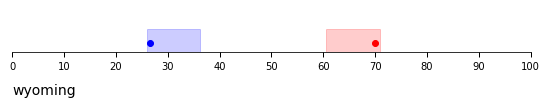

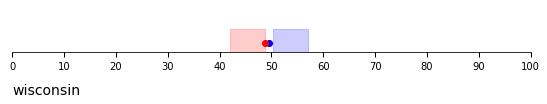

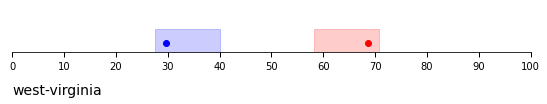

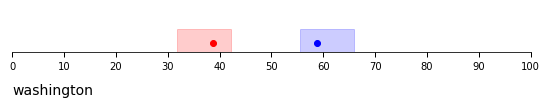

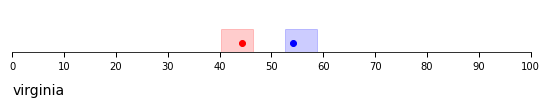

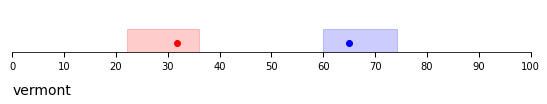

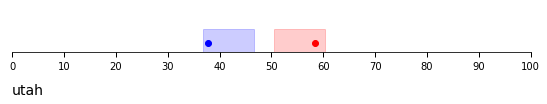

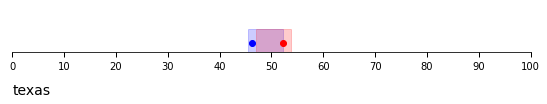

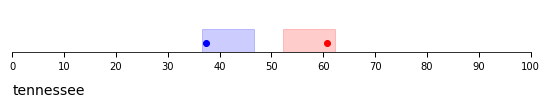

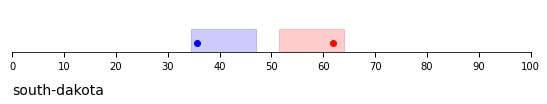

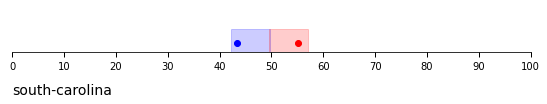

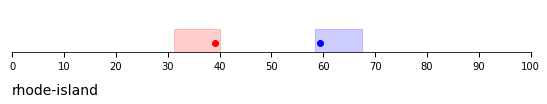

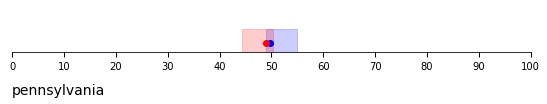

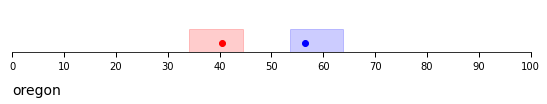

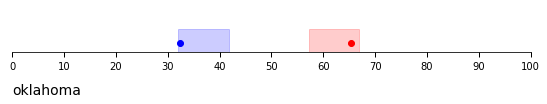

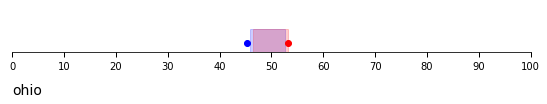

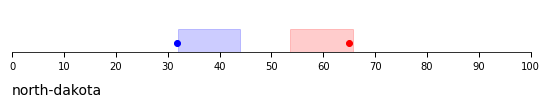

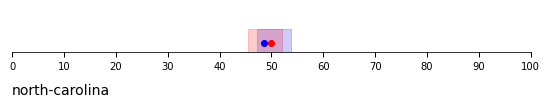

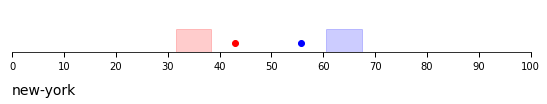

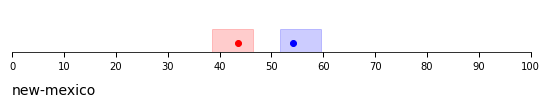

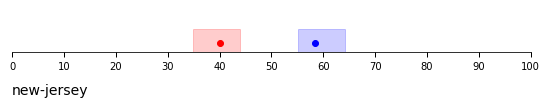

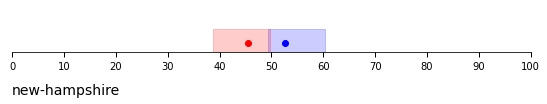

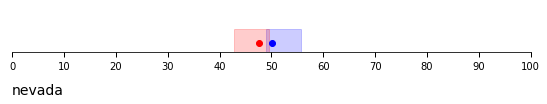

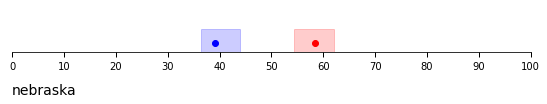

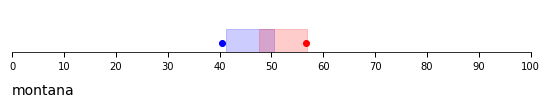

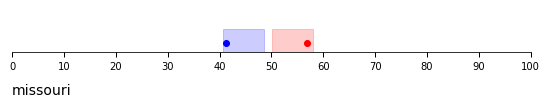

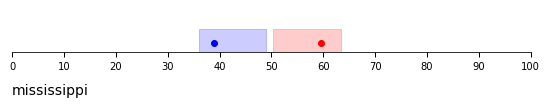

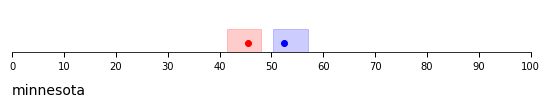

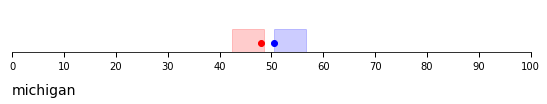

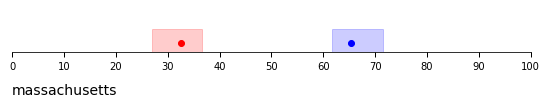

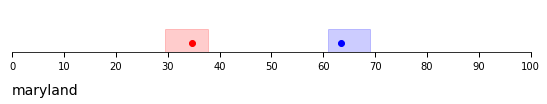

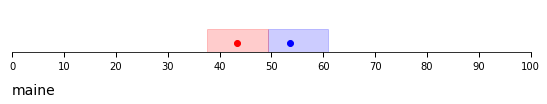

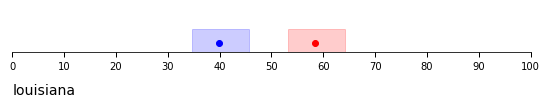

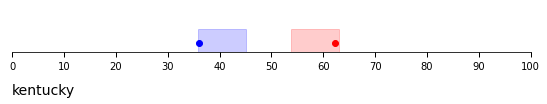

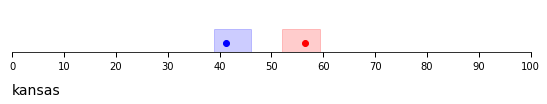

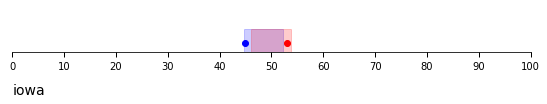

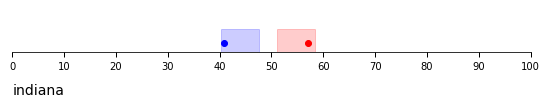

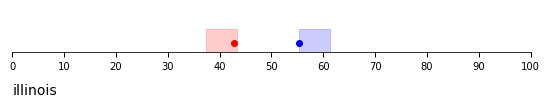

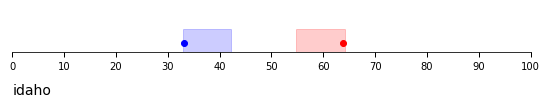

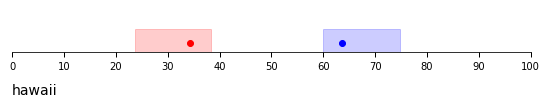

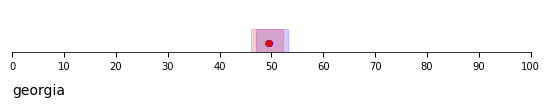

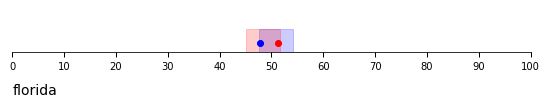

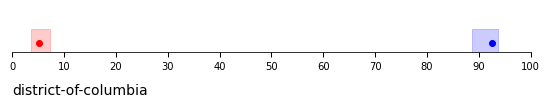

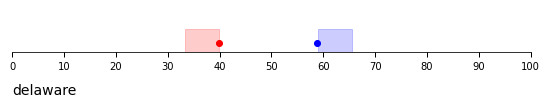

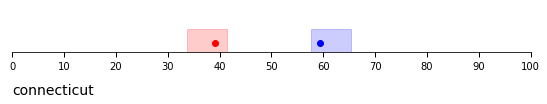

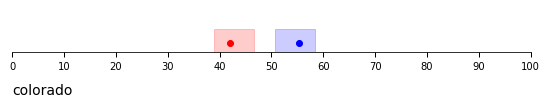

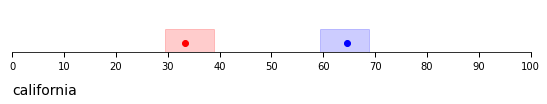

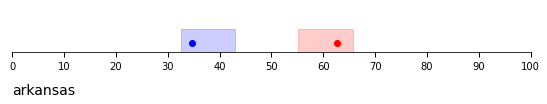

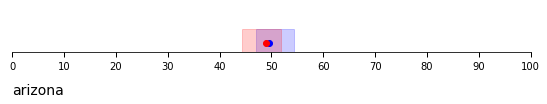

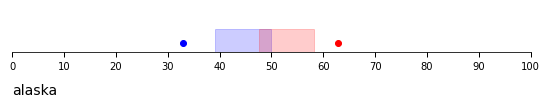

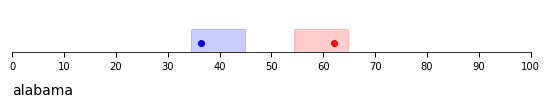

In [208]:
print("This is the output:")

for index, row in master_df.iterrows():
  plt.figure(figsize=(8, 6))
  n = 8
  
  ax = plt.subplot(n, 1, 1)
  setup(ax)
  ax.xaxis.set_major_locator(ticker.MultipleLocator(10))

  # Plotting Challenger Blue
  ax.plot(row['d_real'], 0.2, 'bo', color = 'blue')
  ax.axvspan(xmin = row['voteshare_chal_lo'], xmax = row['voteshare_chal_hi'], ymax = 0.5, alpha=0.2, color='blue')

  # Plotting Incumbent Red
  # Plotting Challenger Blue
  ax.plot(row['r_real'], 0.2, 'bo', color = 'red')
  ax.axvspan(xmin = row['voteshare_inc_lo'], xmax = row['voteshare_inc_hi'], ymax = 0.5, alpha=0.2, color='red')

  ax.text(0, -0.9, row['state'], fontsize=14,transform=ax.transAxes)
  
  # Push the top of the top axes outside the figure because we only show the
  # bottom spine.
  plt.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=1.05)
  plt.show()
